# Incremental Step Test
This script will handle the required post-processing of data for the incremental step test, specified in ASME B5.64. The script will input the csv file generated in Automation 1 for this test and return a completed Incremental Step Test Report if the necessary criteria is passed. It is encouraged to have this script run an Incremental Step Test directly such that if any criteria fails, the test can be adjusted.

Text(value='HEX150-125HL', description='Model Number:', style=TextStyle(description_width='initial'))

Text(value='N/A', description='Serial Number:', style=TextStyle(description_width='initial'))

Text(value='Automation 1', description='Controller Name:', style=TextStyle(description_width='initial'))

Text(value='X = 0 mm, Y = 0 mm, Z = 35 mm', description='Functional Point:', style=TextStyle(description_width…

Text(value='', description='System Location:', style=TextStyle(description_width='initial'))

Text(value='None', description='Load:')

IntText(value=20, description='Temperature ($^\\circ$C):', style=DescriptionStyle(description_width='initial')…

Text(value='', description='Comments:')

Dropdown(description='Units (Must match controller):', index=2, options=(('nm', 'nm'), ('µm', 'um'), ('mm', 'm…

Text(value='', description='Axis:', style=TextStyle(description_width='initial'))

Text(value='Encoder', description='Sensor Name:')

Dropdown(description='Feedback Signal:', options=(('Capacitance Probe', <mode.ai0: 14>), ('Internal Feedback',…

Text(value='None', description='Cap Probe Axis:', style=TextStyle(description_width='initial'))

Dropdown(description='Sample Rate:', options=(('1 kHz', 1000), ('10 kHz', 10000), ('20 kHz', 20000), ('100 kHz…

FloatText(value=0.0, description='Start Position:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0001, description='Step Size (Units)', style=DescriptionStyle(description_width='initial'))

IntText(value=10, description='Number of steps:', style=DescriptionStyle(description_width='initial'))

BoundedFloatText(value=5.0, description='Speed (units/sec):', max=100000.0, style=DescriptionStyle(description…

BoundedFloatText(value=100.0, description='Ramp Rate (units/sec/sec):', max=1000000.0, style=DescriptionStyle(…

BoundedFloatText(value=1.347e-06, description='In-position jitter stdev (Units):', style=DescriptionStyle(desc…

BoundedFloatText(value=0.5, description='Move-and-settle time (sec):', style=DescriptionStyle(description_widt…

BoundedFloatText(value=0.0025, description='Sensitivity (Units/V):', style=DescriptionStyle(description_width=…

BoundedFloatText(value=1.0, description='Average Time (sec):', style=DescriptionStyle(description_width='initi…

Dropdown(description='Direction:', index=1, options=(('Unidirectional', <mode.Unidirectional: 1>), ('Bidirecti…

<IPython.core.display.Javascript object>


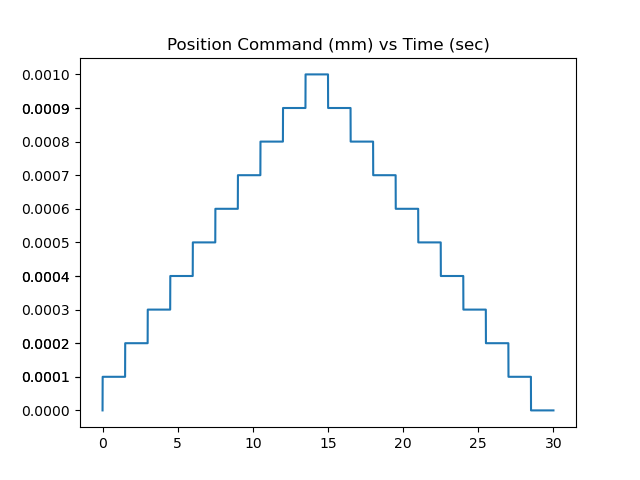

LoadedButton(description='Select Files', layout=Layout(width='20%'), style=ButtonStyle())

LoadedButton(description='Run Incremental Step Test', layout=Layout(width='20%'), style=ButtonStyle())

Button(description='Import Data', layout=Layout(height='80%', width='40%'), style=ButtonStyle())

In [1]:
##Updated by TB 1/8/2024
#Added a dropdown to select cap probe or encoder feedback
#Changed test axis selection to a blank field to be able to key in axis names to match MCD
#Added a field to select axis ai0 for the probe data
#Edited plotting to show either probe or encoder feedback 

%matplotlib notebook

import pandas as pd
from IPython.display import Javascript, HTML, display
import ipywidgets as widgets
from tkinter import Tk, filedialog
from traitlets import traitlets
import automation1 as a1
import sys
import matplotlib.pyplot as plt
import numpy as np
from fpdf import FPDF
import matplotlib.image as image
from matplotlib.animation import FuncAnimation
from threading import Thread
import time
from MinimumIncrementalMotionCollection import incremental_step, step_reversal
import copy
import matplotlib as mpl
import math

#Reach to get AerotechFormat module



sys.path.append('../')
import a1data
from AerotechFormat import AerotechFormat


#Use this class to have buttons store data
class LoadedButton(widgets.Button):
    #Button that can hold a value
    def __init__(self, value = None, *args, **kwargs):
        super(LoadedButton,self).__init__(*args, **kwargs)
        #Create value attribute
        self.add_traits(value = traitlets.Any(value))
        
#Class for updating test figure
class LiveGraph:
    def __init__(self):
        self.x_data, self.y_data = [], []
        self.figure = plt.figure()
        self.line, = plt.plot(self.x_data, self.y_data)
        self.animation = FuncAnimation(self.figure, self.update, interval=200)
        self.th = Thread(target=self.thread_f, daemon=True)
        self.th.start()

    def update(self, frame):
        self.line.set_data(self.x_data, self.y_data)
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()
        plt.yticks(np.unique(self.y_data))
        plt.title('Position Command ({}) vs Time (sec)'.format(Units_w.value))
        return self.line,

    def show(self):
        plt.show()

    def thread_f(self):
        while True:
            self.x_data, self.y_data = self.live_plot_gen()
            time.sleep(.2)
            
    #Live Graph Generation
    def live_plot_gen(self):
        x, y = [0], []
        y.append(StartPos_w.value)
        for i in range(1, NumSteps_w.value+1):
            for j in range((int)((t_ms_w.value+t_ave_w.value) * SamplingRate_w.value)): #Number of points per step
                y.append(StartPos_w.value + i*StepSize_w.value)
        if direction_w.value == a1data.mode.Bidirectional:
            endpos = StartPos_w.value + NumSteps_w.value * StepSize_w.value
            for i in range(1,NumSteps_w.value+1):
                for j in range((int)((t_ms_w.value+t_ave_w.value) * SamplingRate_w.value)): #Number of points per step
                    y.append(endpos - i*StepSize_w.value)
        
        for i in range(1, len(y)):
            x.append(x[i-1] + 1/SamplingRate_w.value)
            #PUT X ARRAY LENGTH HERE
        return x,y
        
#Front End Widgets
#print('System Information \n')
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

sysinfo = "System Information:"

display(HTML(f"<p class='custom-font'>{sysinfo}</p>"))

Type_w = widgets.Text(description = 'System Type:', value = "Linear")
ModelNumber_w = widgets.Text(description = "Model Number:", value = "HEX150-125HL", style= {'description_width': 'initial'}) #System model number/name
SerialNumber_w = widgets.Text(
    value = "N/A", #System serial number
    description = "Serial Number:",
    style= {'description_width': 'initial'}
)
MaxTravel_w = widgets.Text(
    value = "16 mm", #System travel length
    description = "Max Travel Length:",
    style= {'description_width': 'initial'}
)
MaxVelocity_w = widgets.Text(
    value = "5 mm/s", #System max velocity
    description = "Maximum Velocity:",
    style= {'description_width': 'initial'}
)
ControllerName_w = widgets.Text(
    value = "Automation 1",
    description = "Controller Name:",
    style= {'description_width': 'initial'}
)

display(ModelNumber_w,SerialNumber_w,ControllerName_w)

#print('Measurement Information \n')
measinfo = "Measurement Information:"

display(HTML(f"<p class='custom-font'>{measinfo}</p>"))

FunctionalPoint_w = widgets.Text(
    value = "X = 0 mm, Y = 0 mm, Z = 35 mm", #[X,Y,Z], Location of the functional point for the test
    description = "Functional Point:",
    style= {'description_width': 'initial'}
)
SystemLocation_w = widgets.Text(
    description = "System Location:",
    style= {'description_width': 'initial'}
)
Load_w = widgets.Text(
    value = "None",
    description = "Load:",
)
PreTestConditions_w = widgets.Text(
    description = "Pre-test Conditions:",
    style= {'description_width': 'initial'}
)
Temperature_w = widgets.IntText(
    description = "Temperature ($^\circ$C):",
    style= {'description_width': 'initial'},
    value = 20
)
DAS_w = widgets.Text(
    description = "Data Aquisition System:",
    style= {'description_width': 'initial'}
)
Comments_w = widgets.Text(
    description = "Comments:"
)
display(FunctionalPoint_w,SystemLocation_w,Load_w,
       Temperature_w,Comments_w)

#print('Measurement Parameters\n')
measparam = "Measurement Parameters:"

display(HTML(f"<p class='custom-font'>{measparam}</p>"))

warning_style = "<style>.custom-font2 { font-family: 'Bold', sans-serif; font-size: 14px; color: red; font-weight: bold }</style>"

display(HTML(warning_style))

warning = "**Fields in this section are critical when running the Incremental Step test and when importing/post-processing data:"

display(HTML(f"<p class='custom-font2'>{warning}</p>"))

Units_w = widgets.Dropdown(options = [('nm','nm'), ('µm','um'),('mm', 'mm'),('m', 'm'),('deg', 'deg')],
                           description = "Units (Must match controller):",
                           value = 'mm',
                           style= {'description_width': 'initial'}
                          )
Axis = widgets.Text(
    description = 'Axis:',
    options = '',
    style= {'description_width': 'initial'}
)
ProbeAxis_w = widgets.Text(
    description = "Cap Probe Axis:",
    style= {'description_width': 'initial'},
    value = 'None'
)
Signal_w = widgets.Dropdown(
    description = "Feedback Signal:",
    style= {'description_width': 'initial'},
    options = (("Capacitance Probe", a1data.mode.ai0),("Internal Feedback",a1data.mode.pos_fbk))
)
Sensor = widgets.Text(
    description = "Sensor Name:",
    value = "Encoder"
)
SamplingRate_w= widgets.Dropdown(
    description = "Sample Rate:",
    options = [('1 kHz',1000), ('10 kHz', 10000) , ('20 kHz', 20000), ('100 kHz', 100000), ('200 kHz',200000)] #Available sample rates in Automation 1 
)
StartPos_w = widgets.FloatText(
    description = "Start Position:",
    style= {'description_width': 'initial'},
    value = 0
)
StepSize_w = widgets.FloatText(
    description = "Step Size (Units)",
    style= {'description_width': 'initial'},
    value = 0.0001,
)
StepSize_w = widgets.FloatText(
    description = "Step Size (Units)",
    style= {'description_width': 'initial'},
    value = 0.0001, 
)
NumSteps_w = widgets.IntText(
    description = "Number of steps:",
    style= {'description_width': 'initial'},
    value = 10,
)
Speed_w = widgets.BoundedFloatText(
    description = "Speed (units/sec):",
    style= {'description_width': 'initial'},
    value = 5,
    max = 100000,
    min = 0
)
ramprate_w = widgets.BoundedFloatText(
    description = "Ramp Rate (units/sec/sec):",
    style= {'description_width': 'initial'},
    value = 100,
    max = 1000000,
    min = 0
)
s_w = widgets.BoundedFloatText(
    description = "In-position jitter stdev (Units):",
    style= {'description_width': 'initial'},
    value = .000001347,
    min = 0,
)
t_ms_w = widgets.BoundedFloatText(
    description = "Move-and-settle time (sec):",
    style= {'description_width': 'initial'},
    value = .5,
    min = 0,
)
Sensitivity_w = widgets.BoundedFloatText(
    description = "Sensitivity (Units/V):",
    style= {'description_width': 'initial'},
    value = 0.0025,
    min = 0,
)
t_ave_w = widgets.BoundedFloatText(
    description = "Average Time (sec):",
    style= {'description_width': 'initial'},
    value = 1,
    min = 0, 
)
direction_w = widgets.Dropdown(
    description = "Direction:",
    style= {'description_width': 'initial'},
    options = [('Unidirectional', a1data.mode.Unidirectional),('Bidirectional', a1data.mode.Bidirectional)],
    value = a1data.mode.Bidirectional
)
display(Units_w,Axis,Sensor,Signal_w,ProbeAxis_w,SamplingRate_w,StartPos_w, StepSize_w, NumSteps_w, Speed_w, ramprate_w, s_w,t_ms_w,Sensitivity_w,t_ave_w, direction_w)


g = LiveGraph()
g.show()

TestPath = LoadedButton(
    description = "Run Incremental Step Test",
    layout = widgets.Layout(width = '20%')
)
CSVPath = LoadedButton(
    description = "Select Files",
    style= {'description_width': 'initial'},
    layout = TestPath.layout
)
import_data_button = widgets.Button(
    description = 'Import Data',
    layout = widgets.Layout(width = '40%', height = '80%')
)


display(CSVPath, TestPath, import_data_button)

def selectFile(b):
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=False)    # Selected file will be set button's file attribute.
    b.value = pd.read_csv(r'{}'.format(b.files))
    

    CSVPath.description = 'File Selected'
    
def incrementalsteptest(b):
    print("Running incremental step test...")
    global ins,controller
    controller = a1.Controller.connect()
    controller.start()
    
    for axis_index in range(0,1):
            
        # Create status item configuration object
        status_item_configuration = a1.StatusItemConfiguration()
            
        # Add this axis status word to object
        status_item_configuration.axis.add(a1.AxisStatusItem.AxisStatus, axis_index)

        # Get axis status word from controller
        result = controller.runtime.status.get_status_items(status_item_configuration)
        axis_status = int(result.axis.get(a1.AxisStatusItem.AxisStatus, axis_index).value)

        # Check NotVirtual bit of axis status word
        if (axis_status & 1<<13) == 0:
            controller = a1.Controller.connect_usb()

    ins = incremental_step(Axis.value,
                           SamplingRate_w.value,
                           StepSize_w.value,
                           s_w.value,
                           t_ms_w.value,
                           Sensitivity_w.value, 
                           ProbeAxis_w.value,
                           NumSteps_w.value,
                           units = Units_w.value,
                           direction = direction_w.value,
                           t_ave = t_ave_w.value,
                           start_pos = StartPos_w.value,
                           speed = Speed_w.value,
                           ramp_value = ramprate_w.value
    )
    ins.test(controller)
    b.value = ins.to_dataframe()
    display(Javascript("Jupyter.notebook.execute_cells([2])"))
    print('Incremental Step Test Completed')

CSVPath.on_click(selectFile)
TestPath.on_click(incrementalsteptest)

def import_data(b):
    global ins, Comments
    ins = incremental_step(Axis.value,
                           SamplingRate_w.value,
                           StepSize_w.value,
                           s_w.value,
                           t_ms_w.value,
                           Sensitivity_w.value,
                           ProbeAxis_w.value,
                           NumSteps_w.value,
                           units = Units_w.value,
                           direction = direction_w.value,
                           t_ave = t_ave_w.value,
                           start_pos = StartPos_w.value,
                           speed = Speed_w.value,
                           ramp_value = ramprate_w.value
    ) 
    if CSVPath.value is not None:
        ins.populate(dataframe = CSVPath.value)
        CSVPath.files = None
        CSVPath.description = "Select File"
    elif TestPath.value is not None:
        ins.populate(dataframe = TestPath.value)
        TestPath.value = None
    else:
        raise ValueError('Please either run an incremental step test or select CSV files')
    Comments = Comments_w.value
    print('Information successfully imported')
    display(Javascript("Jupyter.notebook.execute_cells([2])"))
    
    
import_data_button.on_click(import_data)

In [ ]:
#print("Data Filters")
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

reset = widgets.Button(
    description = "Reset Filters Applied"
)
display(reset)
print("Butterworth Filter Parameters:")
omega_c = widgets.BoundedFloatText(
    description = "Cut-off Frequency (Hz):",
    style= {'description_width': 'initial'},
    value = 250,
    min = 0,
    max = 1000,
)
order = widgets.BoundedIntText(
    description = "Order:",
    value = 2,
    min = 1,
)
type_w = widgets.Dropdown(
    description = "Type:",
    options = [("High Pass",'high'),("Low Pass",'low')],
    value = 'low'
)
butter = widgets.Button(
    description = "Apply Filter"
)

display(omega_c,order,type_w,butter)

#Button Functions
def reset_func(b):
    global ins, Comments
    ins.pos_fbk = pos_fbk_copy
    Comments = Comments_w.value
    print("Filters Reset")
    
def butter_func(b):
    global ins, Comments
    pos_fbk_copy = copy.deepcopy(ins.pos_fbk)
    ins.butter(a1data.mode.pos_fbk, omega_c.value, order.value, type_w.value)
    Comments = '\n{} pass butterworth filter \n with a {} Hz cut-off frequency applied'.format(type_w.value, omega_c.value)
    print("Butterworth Filter Applied")

    display(Javascript("Jupyter.notebook.execute_cells([3])"))
    
#Button Actions
reset.on_click(reset_func)
butter.on_click(butter_func)



In [ ]:
#print("Plotting and Data Analysis")
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

analysis = "Plotting and Data Analysis:"

display(HTML(f"<p class='custom-font'>{analysis}</p>"))

num_steps = widgets.BoundedIntText(
    min = 0
)
Extra_Signals = widgets.Dropdown(
    description = "Signals To Plot:",
    style = {'description_width': 'initial'},
    options = [('None', False),('Position Error', a1data.mode.pos_err), ('Position Command', a1data.mode.pos_com),('Position Feedback', a1data.mode.pos_fbk)],
    value = False
)
remove_steps = widgets.Dropdown(
    description = "Remove backlash affected steps:",
    style= {'description_width': 'initial'},
    options = [('Yes',True), ('No',False), ('Custom Number', 'Custom Number')],
    value = False
)
custom_num = widgets.BoundedFloatText(
    description = ", Step Reversal Error:",
    style= {'description_width': 'initial'},
    min = 0,
)
step_num_w = widgets.BoundedIntText(
    description = "Step Index to Plot:",
    style= {'description_width': 'initial'},
    min = 0,
    value = 0,
)
sidebyside = widgets.HBox([remove_steps,custom_num])

analyze = widgets.Button(
    description = "Data Analysis"
)

display(sidebyside,step_num_w,Extra_Signals,analyze)
    
def analyze_func(b):
    global data, ins, sr, data_table, criteria_table,B,criteria
    if remove_steps.value == True: #Need to run a step reversal if backlash steps are removed
        print("Running Step Reversal...")
        sr = step_reversal(Axis.value,
                           SamplingRate_w.value,
                           StepSize_w.value*1.5,
                           s_w.value,
                           t_ms_w.value,
                           Sensitivity_w.value,
                           units = Units_w.value,
                           direction = direction_w.value,
                           t_ave = t_ave_w.value,
                           start_pos = StartPos_w.value,
                           speed = Speed_w.value,
                           ramp_value = ramprate_w.value)
        B = sr.test(controller)
        n = math.ceil((B/sr.step_size))
        
        #Set widgets to be the calculated values
        custom_num.value = B
        remove_steps.value = 'Custom Number'
        
        
        print('The step reversal error is: {} {}'.format(B, sr.units))
        print('The number of reverse direction steps neglected are: {}'.format(n))
        if ProbeAxis_w.value == 'None':
            sr.plot(a1data.mode.pos_com, a1data.mode.pos_fbk)
        else:
            sr.plot(a1data.mode.pos_com, a1data.mode.ai0)
        #Incremental Step Data Analysis
        data = ins.data_analysis(step_reversal_error = B)
        display(Javascript("Jupyter.notebook.execute_cells([6])"))
    elif remove_steps.value == False:
        data = ins.data_analysis()

    else:
        B = custom_num.value
        
        data = ins.data_analysis(step_reversal_error = B)
        n = math.ceil((B/sr.step_size))
        
        #Set widgets to be the calculated values
        custom_num.value = B
        remove_steps.value = 'Custom Number'
        
        
        print('The step reversal error is: {:.3e} {}'.format(B, sr.units))
        print('The number of reverse direction steps neglected are: {}'.format(n))
        
    data_table = """<table>
    <tr>
        <th colspan = "3"></th>
        <th colspan = "3">Direction of Motion</th>
    </tr>
    <tr>
        <th colspan = "3"></th>
        <th>Forward</th>
        <th>Reverse</th>
        <th>Combined</th>
    </tr>
    <tr>
        <th colspan = "3">Sample Mean, X<sub>inc</sub> {}</th>
        <td>{:.3e}</td>
        <td>{:.3e}</td>
        <td>{:.3e}</td>
    </tr>
    <tr>
        <th colspan = "3">Sample Standard Deviation, s<sub>inc</sub> {}</th>
        <td>{:.3e}</td>
        <td>{:.3e}</td>
        <td>{:.3e}</td>
    </tr>
    <table>
        
    """.format(ins.units, data['Forward Sample Mean'],data['Reverse Sample Mean'],data['Combined Sample Mean'],
               ins.units, data['Forward Sample Standard Deviation'], data['Reverse Sample Standard Deviation'], 
               data['Combined Sample Standard Deviation'])
    

    
    display(HTML(data_table))
    
    
    #Plotting
    %matplotlib inline
    plt.figure(figsize = (20,10))
    plt.rcParams.update({'font.size': 22})
    plt.title('Staircase Plot')
    if ProbeAxis_w.value == 'None':
        plt.ylabel('Position {}'.format(ins.units))
    else:
        plt.ylabel('Analog Input {}'.format(ins.units))
    
    #Using parent plot method
    if Extra_Signals.value == False:
        if ProbeAxis_w.value=='None':
            super(incremental_step,ins).plot(a1data.mode.pos_fbk)
        else:
            super(incremental_step,ins).plot(a1data.mode.ai0)
    else:
        if ProbeAxis_w.value=='None':
            super(incremental_step,ins).plot(a1data.mode.pos_fbk)
            super(incremental_step,ins).plot(Extra_Signals.value)
        else:
            super(incremental_step,ins).plot(a1data.mode.ai0)
            super(incremental_step,ins).plot(Extra_Signals.value)
    
    #Using child plot method for the pdf generation
    ins.plot(fignum = 3, legend_loc = 'upper right', step_num = step_num_w.value, fig_size = (20,5))
    plt.savefig('IncStepNotebook.png', bbox_inches = 'tight') #save plot to use for report generation
    plt.close()
    
    #Use child plot method for viewing
    ins.plot(legend_loc = 'upper right', step_num = step_num_w.value, fig_size = (20,10))
    
    #Criteria Checking
    criteria = []
    criteria.append(ins.A1()) #0
    criteria.append(ins.A2(data, a1data.mode.positive_direction)) #1
    criteria.append(ins.A3(data, a1data.mode.positive_direction)) #2    
    criteria.append(ins.unidirectional_criteria(data, a1data.mode.positive_direction)) #3
    
    
    criteria.append(ins.A1()) #4
    criteria.append(ins.A2(data, a1data.mode.negative_direction)) #5
    criteria.append(ins.A3(data, a1data.mode.negative_direction)) #6
    criteria.append(ins.unidirectional_criteria(data, a1data.mode.negative_direction)) #7
    
    
    criteria.append(ins.B1()) #8
    criteria.append(ins.B2(data)) #9
    criteria.append(ins.B3(data)) #10
    criteria.append(ins.bidirectional_criteria(data)) #11
    

    
    if criteria[11] == False:
        display(Javascript("Jupyter.notebook.execute_cells([5])"))
    

    
    criteria_table = """

    <table>
        <tr>
            <th colspan = "2"></th>
            <th colspan = "3">Criteria</th>
            <th colspan = "3"></th>
            <th colspan = "3">Criteria</th>
            <th colspan = "2"></th>
        </tr>
        <tr>
            <th colspan = "2">Direction of Motion</th>
            <th>A1</th>
            <th>A2</th>
            <th>A3</th>
            <th colspan = "2">Criteria Satisfied?</th>
            <td></td>
            <th>B1</th>
            <th>B2</th>
            <th>B3</th>
            <th colspan = "2">Criteria Satisfied?</th>
        </tr>
        <tr>
            <th colspan = "2">Forward</th>
            <td>{}</td>
            <td>{}</td>
            <td>{}</td>
            <td colspan = "2">{}</td>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td colspan = "2"></td>
        </tr>
        <tr>
            <th colspan = "2">Reverse</th>
            <td>{}</td>
            <td>{}</td>
            <td>{}</td>
            <td colspan = "2">{}</td>
            <td></td>
            <td></td>
            <td></td>
            <td></td>
            <td colspan = "2"></td>
        </tr>
        <tr>
            <th colspan = "2">Combined</th>
            <td></td>
            <td></td>
            <td></td>
            <td colspan = "2"></td>
            <td></td>
            <td>{}</td>
            <td>{}</td>
            <td>{}</td>
            <td colspan = "2">{}</td>
        </tr>
    </table>
    """.format(*['Yes' if val else 'No' for val in criteria])
    

    #Unpacks the criteria list and maps 'Yes' to True and 'No' to False
    
    
    display(HTML(criteria_table))
    display(Javascript("Jupyter.notebook.execute_cells([4])"))
    
    
    
    
    
    
analyze.on_click(analyze_func)

In [ ]:
##Edited by TB 01/12/2024
#Modified formatting to clean up plots

#Output to pdf
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

pdf = "Generate PDF and CSV:"

display(HTML(f"<p class='custom-font'>{pdf}</p>"))

gen_PDF_button = widgets.Button(
    description = 'Generate PDF'
)


Units = Units_w.value
def gen_PDF(b):
    # This cell of the script will be used to generate a pdf in the AerotechFooter Format
    global fig
    
    plt.rcParams.update({'font.size': 6})
    fig, ax1, ax2, ax3, ax4 = AerotechFormat.makeTemplate()

    
    if ProbeAxis_w.value=='None':
        if Extra_Signals.value == a1data.mode.pos_com:
            #Upper Step Plot
            ax1_up = plt.subplot2grid((14, 3),(2,0), rowspan = 3, colspan = 3)
            ax1_up.plot(ins.time_array, ins.pos_fbk, '-r', label='Position Feedback')
            ax1_up.plot(ins.time_array, ins.pos_com, '-b', label='Position Command')
            plt.title('Incremental Step Test')
            plt.ylabel('Position ({})'.format(ins.units))
            plt.xlabel('Time (seconds)')
            plt.legend(loc='upper right')
            #Lower Step Plot
            ax1_down = plt.subplot2grid((14,5),(6,0), rowspan = 4, colspan = 5)
            ax1_down.axes.get_xaxis().set_ticks([])
            ax1_down.axes.get_yaxis().set_ticks([])
            ax1_down.axis('off')
            inc_step_img = mpl.pyplot.imread('IncStepNotebook.png')
            ax1_down.imshow(inc_step_img, aspect = 'auto')
        elif Extra_Signals.value == a1data.mode.pos_err:
            #Upper Step Plot
            ax1_up = plt.subplot2grid((14,3),(2,0), rowspan = 2, colspan = 3)
            ax1_up.plot(ins.time_array, ins.pos_fbk, '-r', label='Position Feedback')
            plt.title('Incremental Step Test')
            plt.ylabel('Position ({})'.format(ins.units))
            plt.legend(loc='upper right')
            ax1_mid = plt.subplot2grid((14,3),(4,0), rowspan = 2, colspan = 3)            
            ax1_mid.plot(ins.time_array, ins.pos_err, '-b', label='Position Error')
            plt.ylabel('Position Error ({})'.format(ins.units))
            plt.xlabel('Time (seconds)')
            plt.legend(loc='upper right')
            #Lower Step Plot
            ax1_down = plt.subplot2grid((14,5),(7,0), rowspan = 3, colspan = 5)
            ax1_down.axes.get_xaxis().set_ticks([])
            ax1_down.axes.get_yaxis().set_ticks([])
            ax1_down.axis('off')
            inc_step_img = mpl.pyplot.imread('IncStepNotebook.png')
            ax1_down.imshow(inc_step_img, aspect = 'auto')
        else:
            ax1_up = plt.subplot2grid((14, 3),(2,0), rowspan = 3, colspan = 3)
            ax1_up.plot(ins.time_array, ins.pos_fbk, '-r')
            plt.title('Incremental Step Test')
            plt.ylabel('Position ({})'.format(ins.units))
            plt.xlabel('Time (seconds)')
            ax1_down = plt.subplot2grid((14,5),(6,0), rowspan = 4, colspan = 5)
            ax1_down.axes.get_xaxis().set_ticks([])
            ax1_down.axes.get_yaxis().set_ticks([])
            ax1_down.axis('off')
            inc_step_img = mpl.pyplot.imread('IncStepNotebook.png')
            ax1_down.imshow(inc_step_img, aspect = 'auto')
    else:
        if Extra_Signals.value == a1data.mode.pos_com:
            #Upper Step Plot
            ax1_up = plt.subplot2grid((14, 3),(2,0), rowspan = 3, colspan = 3)
            ax1_up.plot(ins.time_array, ins.ai0, '-r', label='Analog Input')
            ax1_up.plot(ins.time_array, ins.pos_com, '-b', label='Position Command')
            plt.title('Incremental Step Test')
            plt.ylabel('Position ({})'.format(ins.units))
            plt.xlabel('Time (seconds)')
            plt.legend(loc='upper right')
            #Lower Step Plot
            ax1_down = plt.subplot2grid((14,5),(6,0), rowspan = 4, colspan = 5)
            ax1_down.axes.get_xaxis().set_ticks([])
            ax1_down.axes.get_yaxis().set_ticks([])
            ax1_down.axis('off')
            inc_step_img = mpl.pyplot.imread('IncStepNotebook.png')
            ax1_down.imshow(inc_step_img, aspect = 'auto')
        elif Extra_Signals.value == a1data.mode.pos_err:
            #Upper Step Plot
            ax1_up = plt.subplot2grid((14,3),(2,0), rowspan = 2, colspan = 3)
            ax1_up.plot(ins.time_array, ins.ai0, '-r', label='Analog Input')
            plt.title('Incremental Step Test')
            plt.ylabel('Position ({})'.format(ins.units))
            plt.legend(loc='upper right')
            ax1_mid = plt.subplot2grid((14,3),(4,0), rowspan = 2, colspan = 3)            
            ax1_mid.plot(ins.time_array, ins.pos_err, '-b', label='Position Error')
            plt.ylabel('Position Error ({})'.format(ins.units))
            plt.xlabel('Time (seconds)')
            plt.legend(loc='upper right')
            #Lower Step Plot
            ax1_down = plt.subplot2grid((14,5),(7,0), rowspan = 3, colspan = 5)
            ax1_down.axes.get_xaxis().set_ticks([])
            ax1_down.axes.get_yaxis().set_ticks([])
            ax1_down.axis('off')
            inc_step_img = mpl.pyplot.imread('IncStepNotebook.png')
            ax1_down.imshow(inc_step_img, aspect = 'auto')
        else:
            ax1_up = plt.subplot2grid((14, 3),(2,0), rowspan = 3, colspan = 3)
            ax1_up.plot(ins.time_array, ins.ai0, '-r')
            plt.title('Incremental Step Test')
            plt.ylabel('Position ({})'.format(ins.units))
            plt.xlabel('Time (seconds)')
            ax1_down = plt.subplot2grid((14,5),(6,0), rowspan = 4, colspan = 5)
            ax1_down.axes.get_xaxis().set_ticks([])
            ax1_down.axes.get_yaxis().set_ticks([])
            ax1_down.axis('off')
            inc_step_img = mpl.pyplot.imread('IncStepNotebook.png')
            ax1_down.imshow(inc_step_img, aspect = 'auto')


    #Results Text Box
    ax2.text(0.02,.8, 'Forward Sample Mean: {:.3e} {}'.format(data['Forward Sample Mean'], ins.units), color = 'black', size = 8.5)
    ax2.text(0.02,.725, 'Reverse Sample Mean: {:.3e} {}'.format(data['Reverse Sample Mean'], ins.units), color = 'black', size = 8.5)
    ax2.text(0.02,.65, 'Combined Sample Mean: {:.3e} {}'.format(data['Combined Sample Mean'], ins.units), color = 'black', size = 8.5)
    ax2.text(0.02,.575, 'Forward Sample StDev: {:.3e} {}'.format(data['Forward Sample Standard Deviation'], ins.units), color = 'black', size = 8.5)
    ax2.text(0.02,.5, 'Reverse Sample StDev: {:.3e} {}'.format(data['Reverse Sample Standard Deviation'], ins.units), color = 'black', size = 8.5)
    ax2.text(0.02,.425, 'Combined Sample StDev: {:.3e} {}'.format(data['Combined Sample Standard Deviation'], ins.units), color = 'black', size = 8.5)
    #ax2.text(0.02,.35, 'Forward Unidirectional Criteria: {}'.format(criteria[3]), color = 'black', size = 8.5)
    #ax2.text(0.02,.275, 'Reverse Unidirectional Criteria: {}'.format(criteria[7]), color = 'black', size = 8.5)
    #ax2.text(0.02,.2, 'Bidirectional Criteria: {}'.format(criteria[11]), color = 'black', size = 8.5)
                
    #Comments Text Box
    ax3.text(.02, .8, 'Serial Number: {}'.format(SerialNumber_w.value), color = 'black', size = 9)
    ax3.text(.02, .725, 'Model Number: {}'.format(ModelNumber_w.value), color = 'black', size = 9)
    ax3.text(.02, .65, 'Axis: {}'.format(Axis.value), color = 'black', size = 9)
    ax3.text(.02, .575, 'Load: {}'.format(Load_w.value), color = 'black', size = 9)
    ax3.text(.02, .5, 'Feedback: {}'.format(Sensor.value), color = 'black', size = 9)
    ax3.text(.02, .425, 'Comments: {}'.format(Comments), color = 'black', size = 7, verticalalignment = 'top')


    #Test Conditions Text Box
    degree_sign = u'\N{DEGREE SIGN}'
    ax4.text(.02, .8, 'Temperature: {}  {}C'.format(Temperature_w.value, degree_sign), color = 'black', size = 9)
    ax4.text(.02, .725, 'In Position Jitter StDev: {} {}'.format(ins.s, ins.units), color = 'black', size = 9)
    ax4.text(.02, .65, 'Move-and-Settle time: {} seconds'.format(ins.t_ms), color = 'black', size = 9)
    ax4.text(.02, .575, 'Average Time: {} seconds'.format(ins.t_ave, ins.units), color = 'black', size = 9)
    ax4.text(.02, .5, 'Sample Rate: {} Hz'.format(1/ins.time_array[1]), color = 'black', size = 9)
    ax4.text(.02, .425, 'Sample Time: {:.3f} seconds'.format(np.max(ins.time_array) + ins.time_array[1]), color = 'black', size = 9)
    ax4.text(.02, .350, 'Step Size: {} {}'.format(StepSize_w.value,ins.units), color = 'black', size = 9)
    ax4.text(.02, .275, 'Start Position: {} {}'.format(ins.start_pos, ins.units), color = 'black', size = 9)
    ax4.text(.02, .200, 'Number of Steps: {}'.format(ins.num_steps), color = 'black', size = 9)
    #ax4.text(.02, .350, 'Axis: {}'.format(Axis.value), color = 'black', size = 9)
    

gen_PDF_button.on_click(gen_PDF)

display(gen_PDF_button)

#Save PDF
output_file = widgets.Text(
    description = 'File Name:',
    value = 'inc_step_report.pdf',
)

export_PDF_button = widgets.Button(
    description = 'Save Generated PDF'
)

def save_PDF(b):
    fig.get_figure().savefig(output_file.value)
    print('PDF saved')

export_PDF_button.on_click(save_PDF)
display(output_file, export_PDF_button)

#Save CSV Button and Textbox
csv_file = widgets.Text(
    description = 'CSV Name:',
    value = 'ins.csv'
)

export_csv_button = widgets.Button(
    description = 'Save CSV'
)

def save_CSV(b):
    ins.write_to_csv(csv_file.value)
    print('CSV saved')
    
export_csv_button.on_click(save_CSV)

#display(Javascript("Jupyter.notebook.execute_cells[5]"))
display(csv_file, export_csv_button)

In [ ]:
#print('A Step Reversal Test is required according to B5.64 for failing the Bidirectional Criteria')
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

pdf = "A Step Reversal Test is required according to B5.64 for failing the Bidirectional Criteria:"

display(HTML(f"<p class='custom-font'>{pdf}</p>"))

CSVPath_sr = LoadedButton(
    description = "Select File",
    layout = widgets.Layout(width = '20%')
)
TestPath_sr = LoadedButton(
    description = "Run Step Reversal Error Test",
    layout = widgets.Layout(width = '20%')
)
import_data_button_sr = LoadedButton(
    description = 'Import Data',
    layout = widgets.Layout(width = '40%', height = '80%')
)


display(CSVPath_sr,TestPath_sr, import_data_button_sr)

def selectFile_sr(b):
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=False)    # Selected file will be set button's file attribute.
    b.value = pd.read_csv(r'{}'.format(b.files))
    

    CSVPath_sr.description = 'File Selected'
    
def stepreversaltest(b):
    global sr
    print("Running a step reversal...")
    sr = step_reversal(Axis.value,
                       SamplingRate_w.value,
                       StepSize_w.value * 1.5,
                       s_w.value,
                       t_ms_w.value,
                       Sensitivity_w.value,
                       ProbeAxis_w.value,
                       NumSteps_w.value,
                       units = Units_w.value,
                       direction = direction_w.value,
                       t_ave = t_ave_w.value,
                       start_pos = StartPos_w.value,
                       speed = Speed_w.value,
                       ramp_value = ramprate_w.value
    )
    B_inc = sr.test(controller)
    b.value = sr.to_dataframe()
    print('Step Reversal Test Completed')
    #Get step reversal error
    B = sr.B_inc()
    print('The incremental step reversal error is: {:.3e} {}'.format(B, sr.units))

    #Update the step reversal widget to include the step reversal error
    custom_num.value = B
    remove_steps.value = 'Custom Number'


    #Plot
    fig_sr = plt.figure(figsize = (20,10))
    plt.title("Incremental Step Reversal Error")
    plt.ylabel("Position ({})".format(sr.units))
    plt.rcParams.update({'font.size': 22})
    if ProbeAxis_w.value=='None':
        sr.plot(a1data.mode.pos_fbk)
        sr.plot(a1data.mode.pos_com)
    else:
        sr.plot(a1data.mode.ai0)
        #sr.plot(a1data.mode.pos_com)
    if Signal_w.value=='mode.pos_fbk':    
        plt.legend(["Position Feedback", "Position Command"])
    else:
        plt.legend(["Analog Input"])
    display(Javascript("Jupyter.notebook.execute_cells([7])"))

CSVPath_sr.on_click(selectFile_sr)
TestPath_sr.on_click(stepreversaltest)

def import_data_sr(b):
    global sr
    Units = sr.units
    sr = step_reversal(Axis.value,
                       SamplingRate_w.value,
                       StepSize_w.value*1.5,
                       s_w.value,
                       t_ms_w.value,
                       Sensitivity_w.value,
                       units = Units_w.value,
                       direction = direction_w.value,
                       t_ave = t_ave_w.value,
                       start_pos = StartPos_w.value, 
                       speed = Speed_w.value,
                       ramp_value = ramprate_w.value
    ) 
    if CSVPath_sr.value is not None:
        sr.populate(dataframe = CSVPath_sr.value)
        CSVPath_sr.files = None
        CSVPath_sr.description = "Select File"
    elif TestPath_sr.value is not None:
        sr.populate(dataframe = TestPath_sr.value)
        TestPath_sr.value = None
    else:
        raise ValueError('Please either run a step reversal test or select a CSV file')
    display(Javascript("Jupyter.notebook.execute_cells([6])"))
    print('Information successfully imported')
    
import_data_button_sr.on_click(import_data_sr)

In [ ]:
#Get step reversal error
B = sr.B_inc()
print('The incremental step reversal error is: {:.3e} {}'.format(B, sr.units))

#Update the step reversal widget to include the step reversal error
custom_num.value = B
remove_steps.value = 'Custom Number'


#Plot
fig_sr = plt.figure(figsize = (20,10))
plt.title("Incremental Step Reversal Error")
plt.ylabel("Position ({})".format(sr.units))
plt.rcParams.update({'font.size': 22})


sr.plot(a1data.mode.pos_fbk, a1data.mode.pos_com)
plt.legend(["Position Feedback", "Position Command"])
display(Javascript("Jupyter.notebook.execute_cells([7])"))

In [ ]:
#Output to pdf
custom_style = "<style>.custom-font { font-family: 'Bold', sans-serif; font-size: 16px; color: black; font-weight: bold }</style>"

display(HTML(custom_style))

pdf = "Generate Step Reversal PDF and CSV:"

display(HTML(f"<p class='custom-font'>{pdf}</p>"))

gen_PDF_button = widgets.Button(
    description = 'Generate PDF'
)



def gen_PDF(b):
    # This cell of the script will be used to generate a pdf in the AerotechFooter Format
    global fig
    
    B = sr.B_inc()
    
    plt.rcParams.update({'font.size': 6})
    fig, ax1, ax2, ax3, ax4 = AerotechFormat.makeTemplate()

    #Step Reversal Plot
    if ProbeAxis_w.value=='None':
        ax1.plot(sr.time_array,sr.pos_fbk)
        ax1.plot(sr.time_array,sr.pos_com)
    else:
        ax1.plot(sr.time_array,sr.ai0)
        ax1.plot(sr.time_array,sr.pos_com)
    ax1.set_title('Incremental Step Reversal Error')
    ax1.set_ylabel('Position ({})'.format(sr.units))
    ax1.set_xlabel('Time (seconds)')
    ax1.legend(["Position Feedback","Position Command"])
    
    
    #Results Text Box
    ax2.text(0.02,.8, 'Step Reversal Error: {:.3e} {}'.format(B, sr.units), color = 'black', size = 9)
    
                
    #Comments Text Box
    ax3.text(.02, .8, 'Serial Number: {}'.format(SerialNumber_w.value), color = 'black', size = 9)
    ax3.text(.02, .725, 'Model Number: {}'.format(ModelNumber_w.value), color = 'black', size = 9)
    ax3.text(.02, .65, 'Stage Type: {}'.format(Type_w.value), color = 'black', size = 9)
    ax3.text(.02, .575, 'Controller: {}'.format(ControllerName_w.value), color = 'black', size = 9)
    ax3.text(.02, .5, 'Feedback: {}'.format(Sensor.value), color = 'black', size = 9)


    #Test Conditions Text Box
    degree_sign = u'\N{DEGREE SIGN}'
    ax4.text(.02, .8, 'Temperature: {}  {}C'.format(Temperature_w.value, degree_sign), color = 'black', size = 9)
    #ax4.text(.02, .725, 'Humidity: XX', color = 'black', size = 9)
    #ax4.text(.02, .65, 'Pressure: XX', color = 'black', size = 9)
    #ax4.text(.02, .575, 'Base Vibration: XX', color = 'black', size = 9)
    ax4.text(.02, .5, 'Sample Rate: {} Hz'.format(1/ins.time_array[1]), color = 'black', size = 9)
    ax4.text(.02, .425, 'Sample Time: {:.3f} seconds'.format(np.max(ins.time_array) + ins.time_array[1]), color = 'black', size = 9)
    ax4.text(.02, .350, 'Axis: {}'.format(Axis.value), color = 'black', size = 9)
    

gen_PDF_button.on_click(gen_PDF)

display(gen_PDF_button)

#Save PDF
output_file = widgets.Text(
    description = 'File Name:',
    value = 'step_reversal_report.pdf',
)

export_PDF_button = widgets.Button(
    description = 'Save Generated PDF'
)

def save_PDF(b):
    fig.get_figure().savefig(output_file.value)
    print('PDF saved')

export_PDF_button.on_click(save_PDF)
display(output_file, export_PDF_button)

#Save CSV Button and Textbox
csv_file_sr = widgets.Text(
    description = 'CSV Name:',
    value = 'sr.csv'
)

export_csv_button_sr = widgets.Button(
    description = 'Save CSV'
)

def save_CSV_sr(b):
    sr.write_to_csv(csv_file_sr.value)
    print('CSV saved')
    
export_csv_button_sr.on_click(save_CSV_sr)

display(csv_file_sr, export_csv_button_sr)